In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [3]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [4]:
plt.rc('font', family='NanumBarunGothic') #set font
plt.rc('axes', unicode_minus=False)

# Load data

In [39]:
df = pd.read_csv('/content/gdrive/MyDrive/SolarPower/DropColsData.csv') #상관관계 높은 열 제거한 데이터
print(df.shape)
df.head()

(129117, 14)


,지역,시간,발전량,일자,기온,풍속,풍향,습도,해면기압,일사,전운량,시정,PM10,월
0,전남 목포시,0,0.0,2013-01-01,-2.0,4.1,160.0,93.0,1021.4,NaN,3.0,2000.0,135.0,1
1,전남 목포시,1,0.0,2013-01-01,-2.2,3.7,160.0,95.0,1021.3,NaN,NaN,NaN,44.0,1
2,전남 목포시,2,0.0,2013-01-01,-2.4,3.6,160.0,95.0,1021.2,NaN,NaN,NaN,34.0,1
3,전남 목포시,3,0.0,2013-01-01,-2.7,3.6,160.0,95.0,1020.8,NaN,7.0,1800.0,41.0,1
4,전남 목포시,4,0.0,2013-01-01,-2.9,4.0,160.0,94.0,1020.0,NaN,7.0,1800.0,41.0,1


In [40]:
#지역별로 데이터 분리
def AreaSplit(data):
  area_name = ['Jj', 'Mp', 'Gn' ] 
  for idx, area in enumerate(['경남 진주시', '전남 목포시', '강원 강릉시']): 
    name = area_name[idx]
    area = data[data['지역'] == area]
    area.reset_index(drop=True, inplace=True)
    globals()[f'{name}_df'] = area
  return Jj_df, Mp_df, Gn_df

In [41]:
Jj_df, Mp_df, Gn_df = AreaSplit(df)
print(f'전체데이터: {data.shape},\n목포시 : {Mp_df.shape},\n강릉시 : {Gn_df.shape},\n진주시 : {Jj_df.shape}')

전체데이터: (30944, 14),
목포시 : (60796, 14),
강릉시 : (35063, 14),
진주시 : (33258, 14)


# Distribution of Area

In [45]:
df.columns

Index(['지역', '시간', '발전량', '일자', '기온', '풍속', '풍향', '습도', '해면기압', '일사', '전운량',
       '시정', 'PM10', '월'],
      dtype='object')

In [91]:
def scatter(area_df, target, name):
  col_list = [x for x in df.columns if x not in ['지역', '일자', '시간', '월','발전량']]
  plt.figure(figsize=(16,14))
  for idx, col in enumerate(col_list):
    ax = plt.subplot(3, 3, idx+1)
    sns.regplot(x = area_df[target], y = area_df[col] , data = area_df, scatter_kws = {'color':'b', 's':6}, line_kws = {'color':'r'})
    ax.set_title(f'{target} ~ {col}', fontsize = 12)
    ax.set_xlabel(f'{target}', fontsize = 8)
    ax.set_ylabel(f'{col}') 
  
  plt.suptitle(f'{name} Scatter Diagram', fontsize = 20, position=(0.5,0.92)) 
  plt.show()

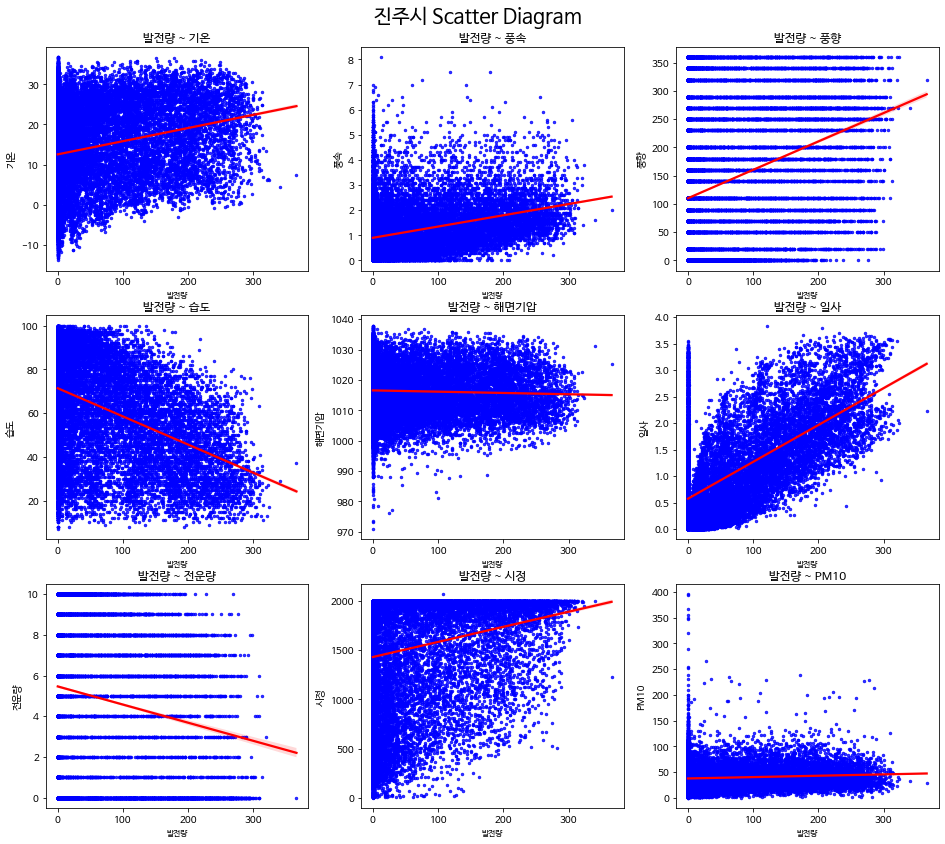

In [47]:
scatter(Jj_df, '발전량', "진주시")

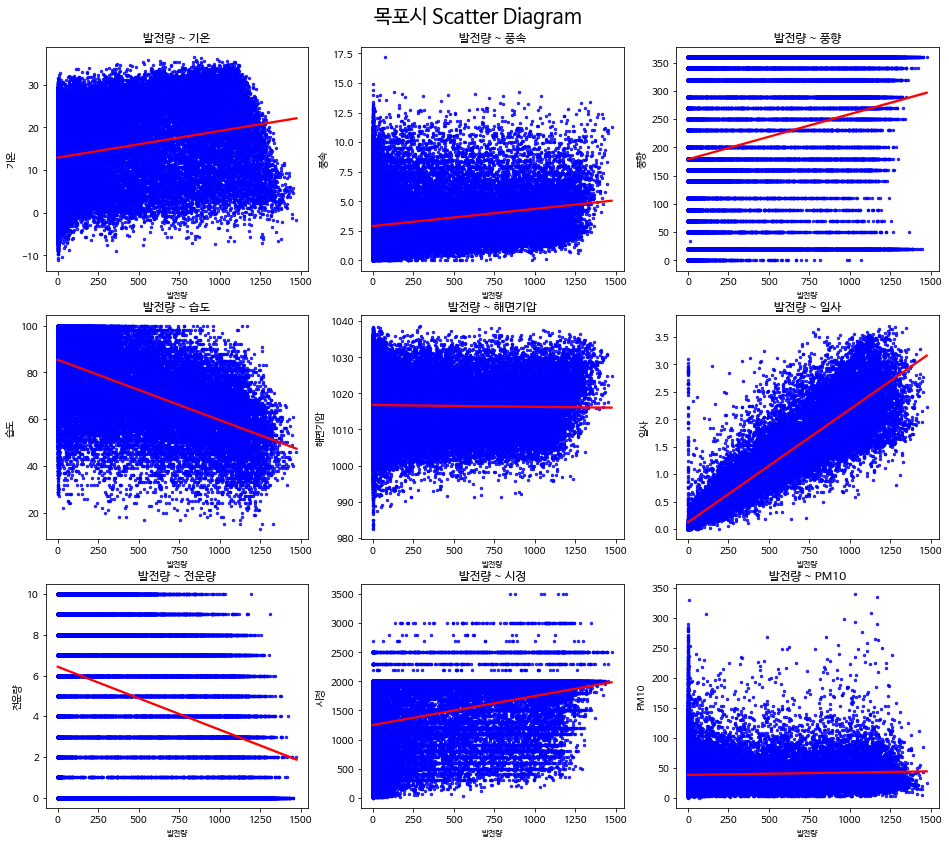

In [48]:
scatter(Mp_df, '발전량',  "목포시")

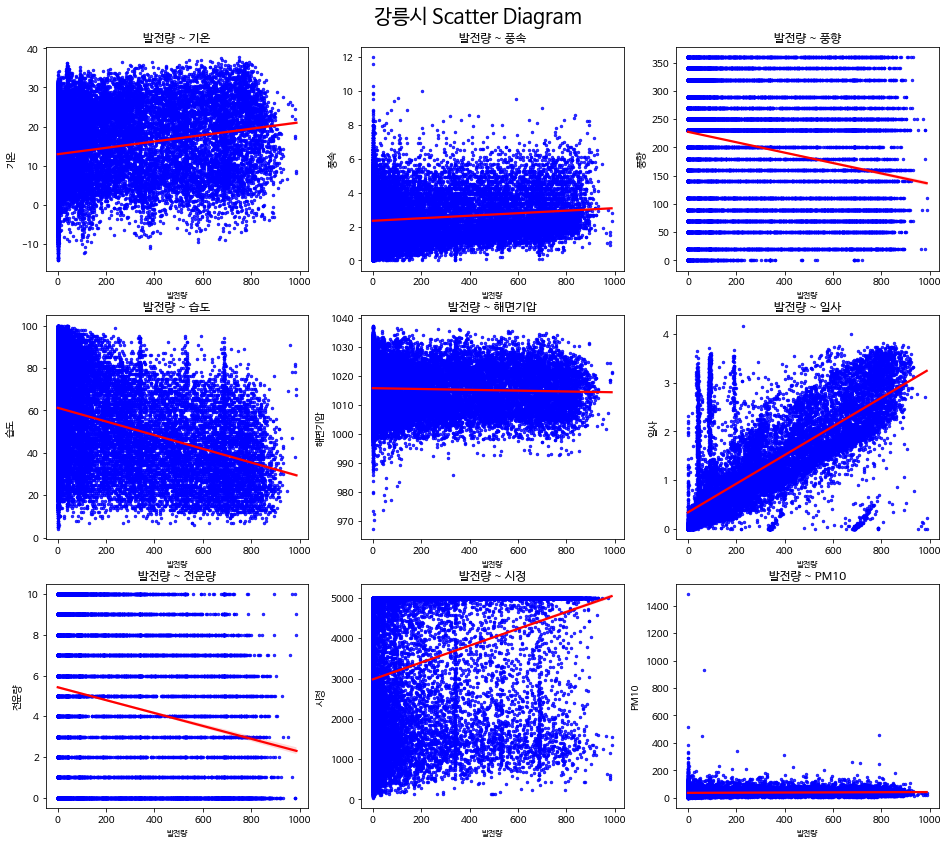

In [49]:
scatter(Gn_df, '발전량', "강릉시")

In [100]:
def day_plot(area_df, name): # 모든 시간 데이터의 평균 분포
  col_list = [x for x in df.columns if x not in ['지역', '일자', '시간', '월']]
  plt.figure(figsize=(23,18))
  plt.suptitle(f'{name} distribution of the day', fontsize=25, position=(0.5,0.92))
  for idx, col in enumerate(col_list):
    ax = plt.subplot(4, 4, idx+1)
    data = pd.DataFrame()
    for h in range(0,24):
      t_mean = area_df[area_df['시간'] == h][col].mean()
      mean_df = pd.DataFrame([[h, t_mean]],columns = ['시간', '평균'])
      data = pd.concat([data, mean_df])
    plt.plot(range(len(data)), data['평균'])
    ax.set_title(f'{col}', fontsize=15)
    # ax.set_xlabel('시간')
    ax.set_xticks(range(len(data)))

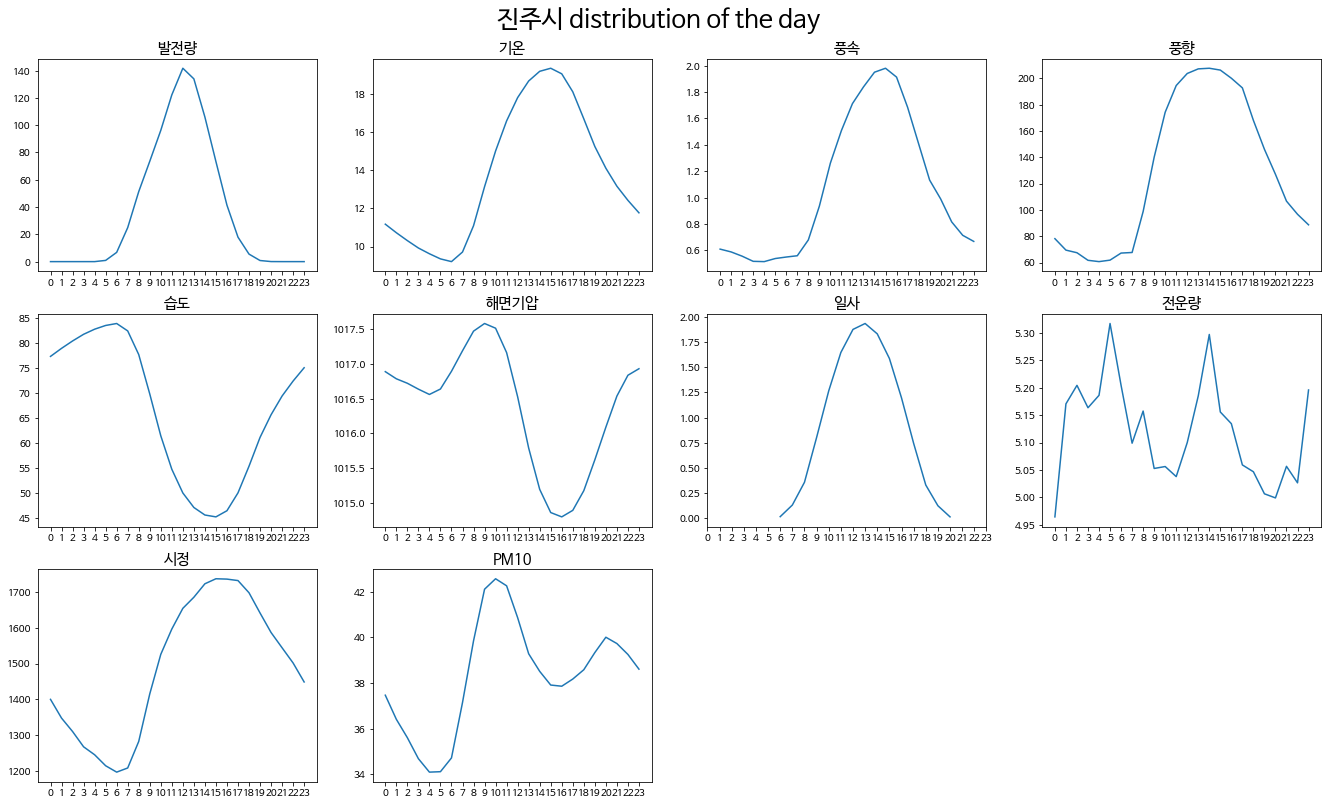

In [51]:
day_plot(Jj_df, '진주시')

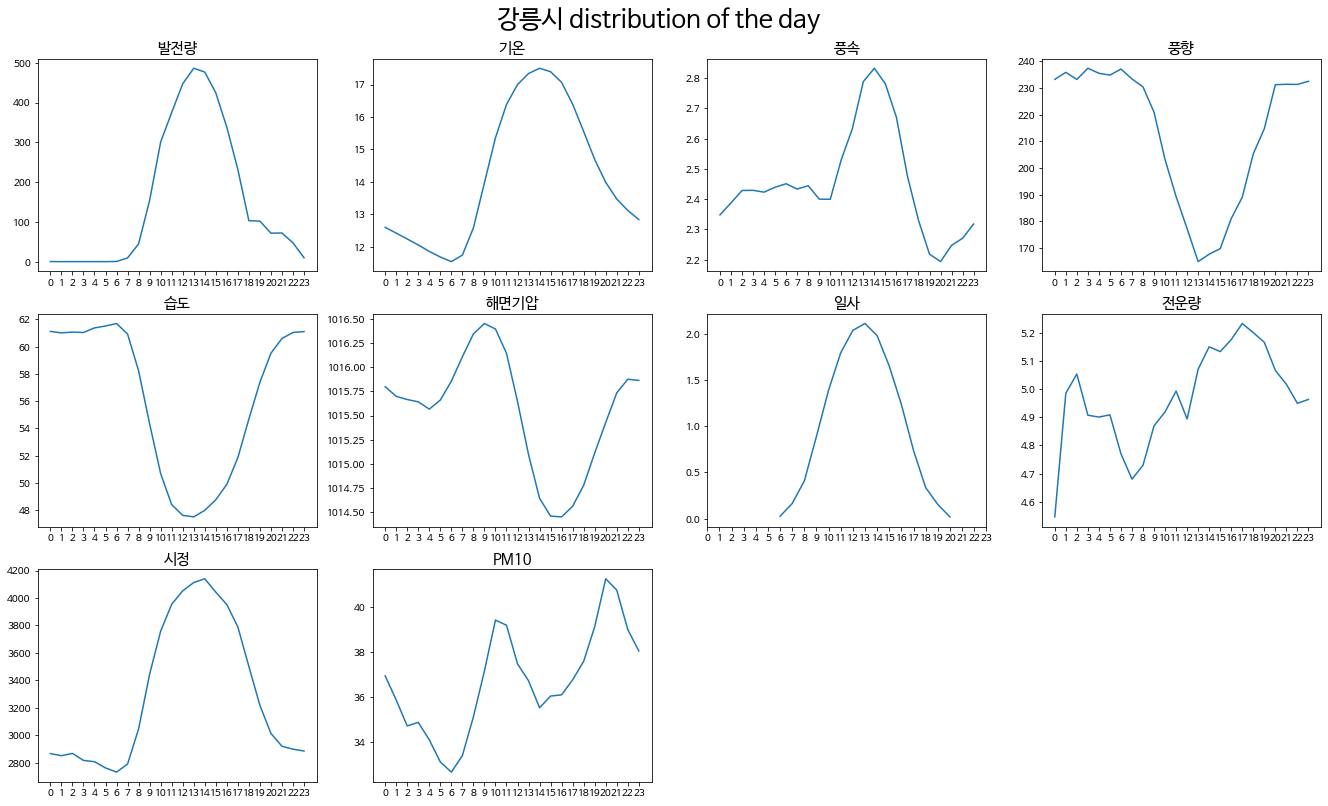

In [52]:
day_plot(Gn_df, '강릉시')

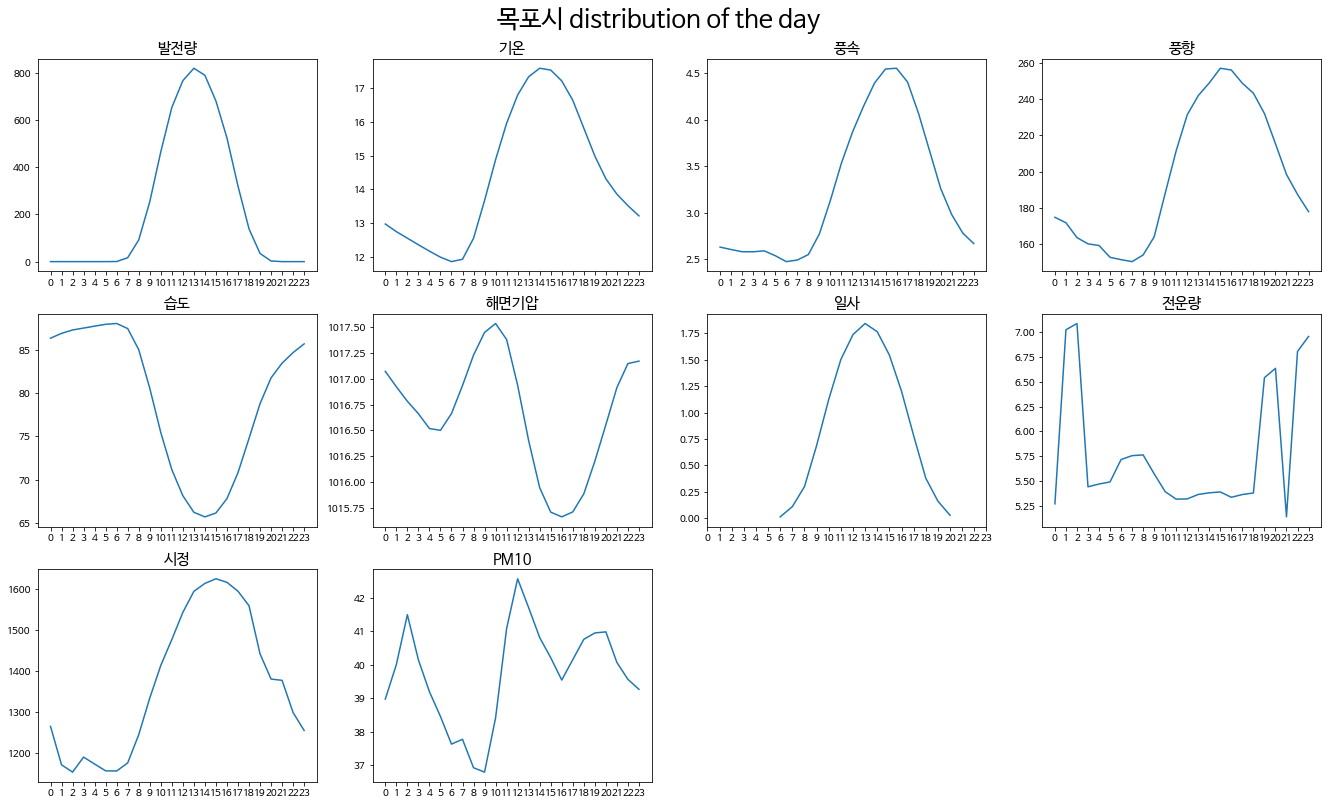

In [53]:
day_plot(Mp_df,'목포시')

In [62]:
def NullPlot(data, title):
  cols = [x for x in data.columns if x not in ['지역','일자','시간','월']]

  fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20,12), nrows=2, ncols=2)
  plt.suptitle(title, fontsize=20)
  
  df_list = [data, Mp_df, Jj_df, Gn_df]
  area_title = ['All Data', 'MokPo', 'JinJo', 'GangNeung']
  for idx,ax in enumerate([ax1, ax2, ax3, ax4]):
    null_list = df_list[idx][cols].isnull().sum()
    
    # null이 많을수록 색 진하게
    pal = sns.color_palette("Blues", len(cols))
    rank = null_list.argsort().argsort()
    bar = ax.bar(range(1,len(cols)+1), null_list.values, color=np.array(pal)[rank])
    # title 설정
    ax.set_title(area_title[idx], fontsize=20)
    ax.set_xticks(range(1, len(cols)+1))
    ax.set_xticklabels(cols)
    ax.set_xlabel('variables', fontsize=15)
    ax.set_ylabel('Null', fontsize=15)
    ax.set_ylim(0,62000)

    for b in bar:
      x = b.get_x() + b.get_width()/2.0
      y = b.get_height()
      ax.text(x, y, y, ha='center', va='bottom', fontsize=13)
  plt.show()

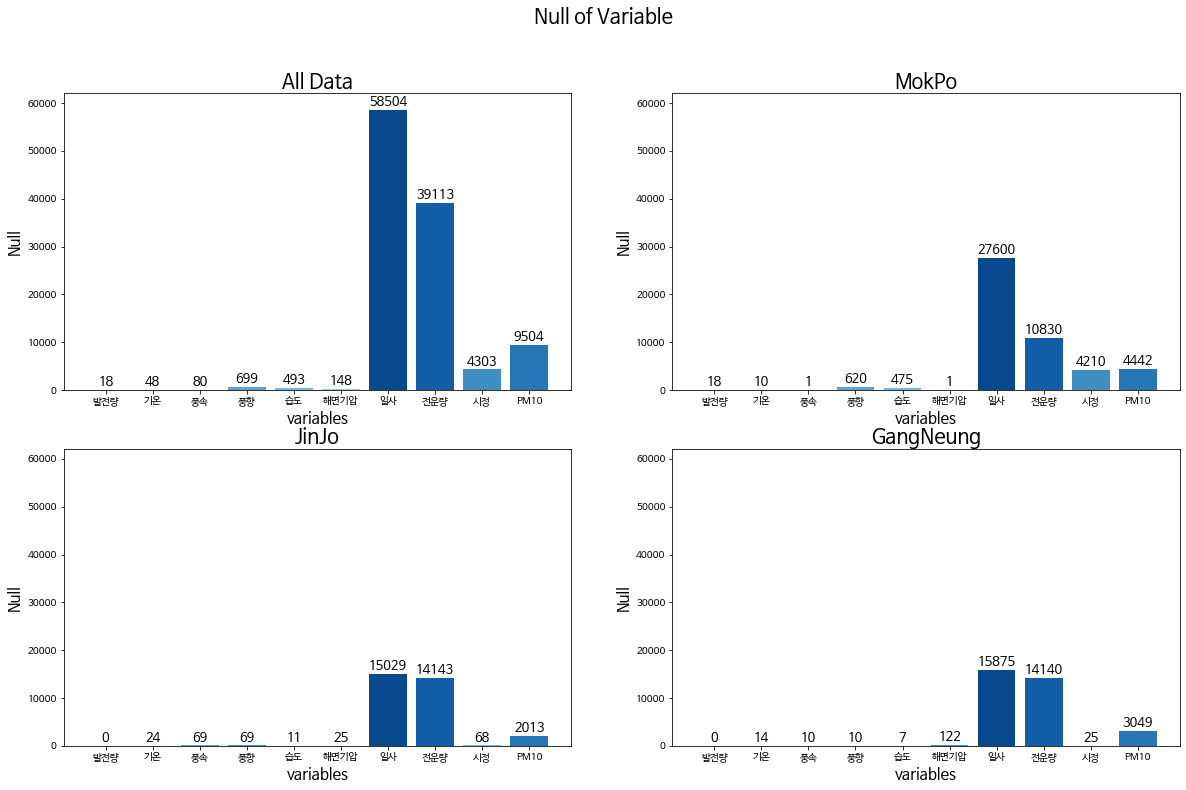

In [63]:
NullPlot(df, 'Null of Variable')

# Delete Nighttime

In [64]:
def drop_idx(df):
  data = df.copy()
  idx = data[data['발전량'] == 0].index
  data.drop(idx, inplace=True)
  data.dropna(subset=['발전량'], inplace=True)
  data.reset_index(inplace=True, drop=True)
  return data

In [65]:
drop_data = drop_idx(df)

In [66]:
time_df = []
drop_df = []
for h in df['시간'].unique():
  all_df = df[df['시간'] == h]
  drop_null = drop_data[drop_data['시간'] == h]
  time_df.append(len(all_df))
  drop_df.append(len(drop_null))

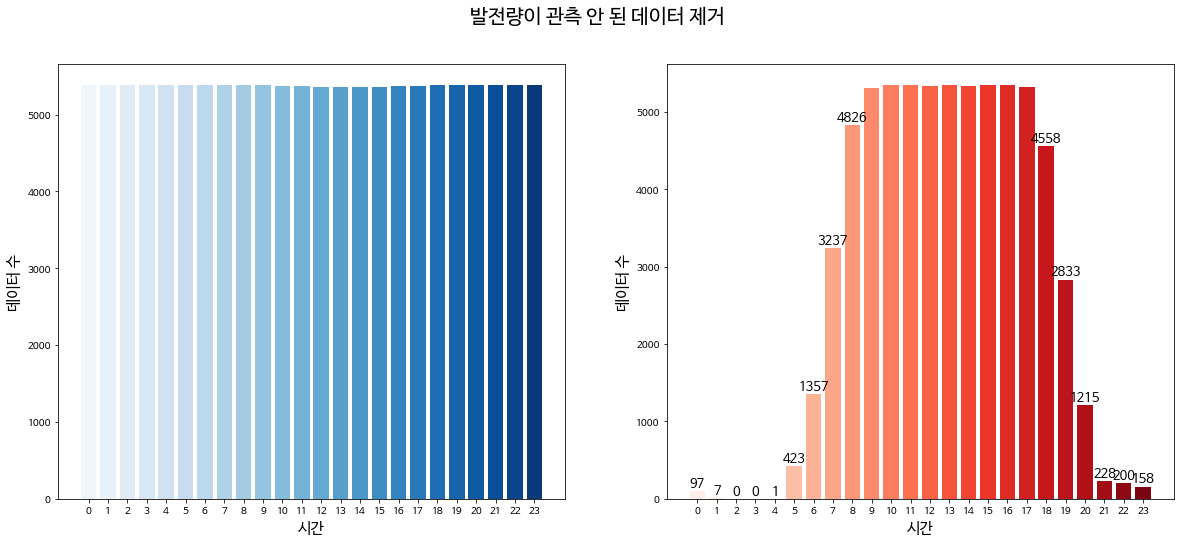

In [67]:
fig, [ax1,ax2] = plt.subplots(figsize=(20,8), nrows=1, ncols=2)

pal1 = sns.color_palette("Blues", len(l1))
pal2 = sns.color_palette("Reds", len(l2))

plt.suptitle(f'발전량이 관측 안 된 데이터 제거', fontsize=20)
ax1.set_xticks(range(0,24))
ax1.set_xticklabels(range(0,24))
ax1.set_xlabel('시간', fontsize=15)
ax1.set_ylabel('데이터 수', fontsize=15)

ax1.bar(range(0,len(time_df)), time_df, color=pal1)
# ax2 = ax1.twinx().twiny()
bar = ax2.bar(range(0,len(drop_df)), drop_df, color=pal2)
ax2.set_xticks(range(0,24))
ax2.set_xticklabels(range(0,24))
ax2.set_xlabel('시간', fontsize=15)
ax2.set_ylabel('데이터 수', fontsize=15)

for b in bar:
  x = b.get_x() + b.get_width()/2.0
  y = b.get_height()
  if y <= 5000:
    ax2.text(x, y, y, ha='center', va='bottom', fontsize=13)
plt.show()

In [73]:
def drop_idx(df, drop_times):
  data = df.copy()
  drop_idx = []
  night_idx = data[data['시간'].isin(drop_times)].index # 밤 시간대 제거
  zero_idx = data[data['발전량'] == 0].index # 그 외에도 발전량이 0인 행 제거
  drop_idx.extend([i for i in night_idx])
  drop_idx.extend([i for i in zero_idx])
  data.drop(drop_idx, inplace=True)
  data.dropna(subset=['발전량'], inplace=True)
  data.reset_index(inplace=True, drop=True)
  return data

In [74]:
drop_times = [0,1,2,3,4,21,22,23]
daytime_df = drop_idx(df, drop_times)
daytime_df

,지역,시간,발전량,일자,기온,풍속,풍향,습도,해면기압,일사,전운량,시정,PM10,월
0,전남 목포시,9,20.160,2013-01-01,2.6,6.0,290.0,91.0,1019.6,0.03,10.0,1300.0,43.0,1
1,전남 목포시,10,106.800,2013-01-01,4.2,5.8,250.0,82.0,1019.9,0.57,7.0,1300.0,56.0,1
2,전남 목포시,11,469.560,2013-01-01,3.8,7.1,320.0,80.0,1020.5,1.00,9.0,1300.0,75.0,1
3,전남 목포시,12,504.240,2013-01-01,4.9,2.8,290.0,73.0,1020.1,1.05,7.0,1300.0,84.0,1
4,전남 목포시,13,745.200,2013-01-01,5.2,6.7,320.0,66.0,1019.7,1.14,6.0,1100.0,78.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66470,강원 강릉시,15,401.280,2020-12-31,0.3,4.5,230.0,27.0,1019.1,1.47,0.0,5000.0,16.0,12
66471,강원 강릉시,16,382.464,2020-12-31,-0.1,4.0,230.0,29.0,1019.2,0.94,0.0,5000.0,13.0,12
66472,강원 강릉시,17,150.048,2020-12-31,-1.8,4.0,250.0,34.0,1019.5,0.36,0.0,5000.0,20.0,12
66473,강원 강릉시,19,320.352,2020-12-31,-4.0,5.4,230.0,40.0,1020.0,NaN,0.0,4333.0,22.0,12


In [75]:
daytime_df['시간'].unique()

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,  8, 19,  7, 20,  6,  5])

In [76]:
Jj_df, Mp_df, Gn_df = AreaSplit(daytime_df)
print(f'전체데이터: {data.shape},\n목포시 : {Mp_df.shape},\n강릉시 : {Gn_df.shape},\n진주시 : {Jj_df.shape}')

전체데이터: (30944, 14),
목포시 : (30944, 14),
강릉시 : (17671, 14),
진주시 : (17860, 14)


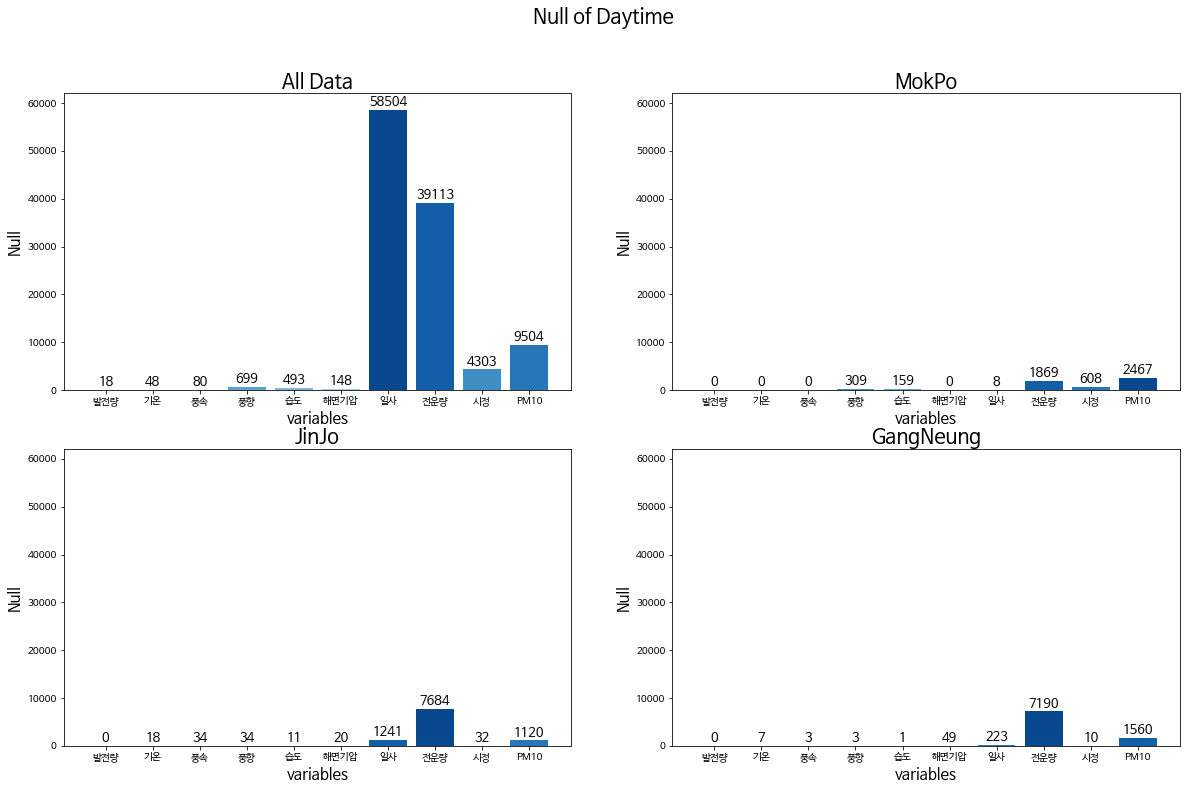

In [77]:
NullPlot(df, 'Null of Daytime')

# Final Data
Remove missing values

In [83]:
data = daytime_df.dropna(how='any')
data.reset_index(inplace=True, drop=True)
data.shape 

(43771, 14)

In [84]:
def timebar(df, area, title, ylim): #데이터 들어있는 시간 합계 구하기
  test_df = df[df['지역'] == area] #원하는 지역 분리
  # test data set의 월별 시간 합 구하기
  dic = {}
  for i in range(1,13):
    time_df = test_df[test_df['월'] == i] 
    sum_num = time_df['시간'].sum()
    dic[i] = sum_num

  time_list = dic.items()
  x, y = zip(*time_list)

  # 값이 큰 순서대로 컬러 넣기
  pal = sns.color_palette("Blues", len(x)) # 기본 컬러바
  sorted_month = [x[0] for x in sorted(time_list, key = lambda num:num[1])] #시간이 가장 많은 월 순서
  zero_array = np.zeros(12, dtype=int) #월별 순위를 넣을 공간
  for idx, i in enumerate(sorted_month):
    if sorted_month[idx] == i:
      zero_array[sorted_month[idx]-1] = idx
  rank_list = [i for i in zero_array]

  fig, ax = plt.subplots(figsize=(10,4))
  bar = ax.bar(x, y, alpha=0.7, color= np.array(pal)[rank_list]) #기본바를 위에 시간 순위를 기준으로 색 변경
  plt.title(f'{title} 월별 시간합계', fontsize=20, pad=10)
  plt.xticks(x, [f'{m}월' for m in x])
  plt.ylabel('시간 합계')
  plt.ylim(ylim)
  plt.xlabel('월')

  bar = ax.bar(x, y, alpha=0.7, color= np.array(pal)[rank_list])
  for i, b in enumerate(bar):
    x_text = b.get_x() + b.get_width()/2.0
    y_text = b.get_height()
    ax.text(x_text, y_text, f'{y_text}h', ha='center', va='bottom', fontsize=10)
  plt.show()

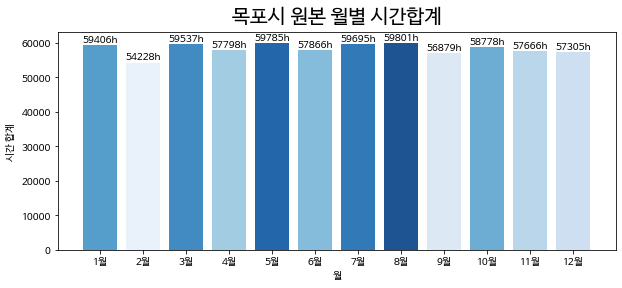

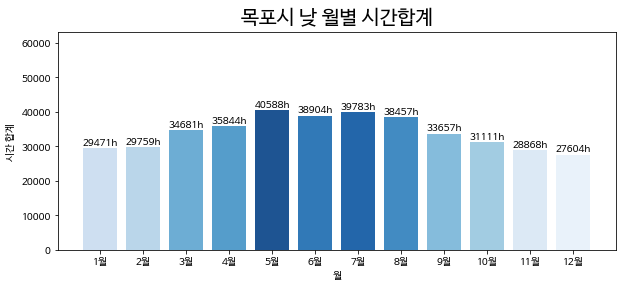

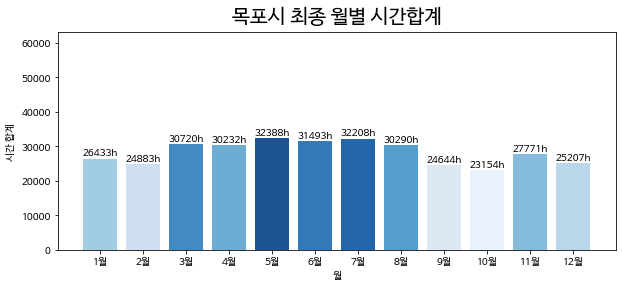

In [85]:
timebar(df, '전남 목포시', '목포시 원본', [0,63000])
timebar(daytime_df, '전남 목포시', '목포시 낮', [0,63000])
timebar(data, '전남 목포시', '목포시 최종', [0,63000])

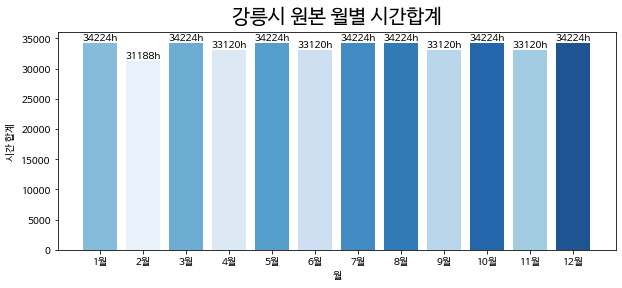

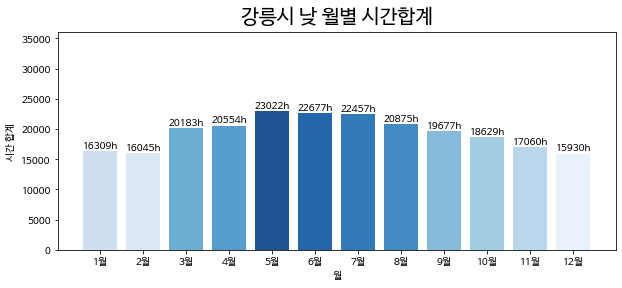

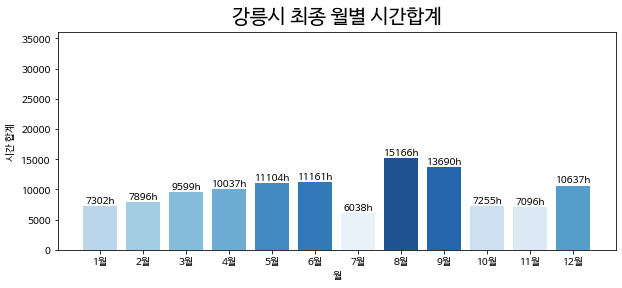

In [86]:
timebar(df, '강원 강릉시', '강릉시 원본', [0,36000])
timebar(daytime_df, '강원 강릉시', '강릉시 낮', [0,36000])
timebar(data, '강원 강릉시', '강릉시 최종', [0,36000])

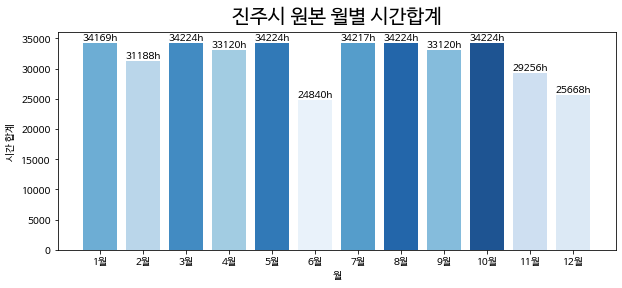

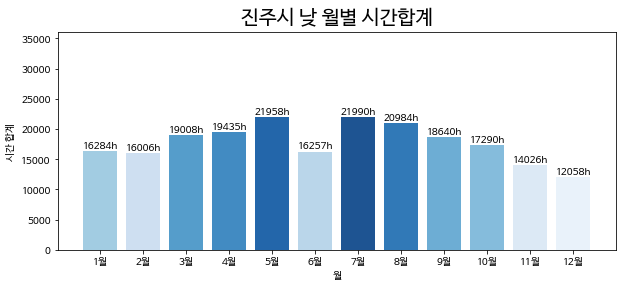

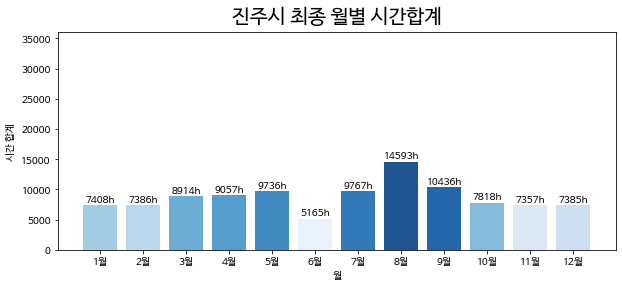

In [87]:
timebar(df, '경남 진주시', '진주시 원본', [0,36000])
timebar(daytime_df, '경남 진주시', '진주시 낮', [0,36000])
timebar(data, '경남 진주시', '진주시 최종', [0,36000])

In [88]:
Jj_df, Mp_df, Gn_df = AreaSplit(data)
print(f'최종 데이터: {data.shape},\n목포시 : {Mp_df.shape},\n강릉시 : {Gn_df.shape},\n진주시 : {Jj_df.shape}')

최종 데이터: (43771, 14),
목포시 : (26389, 14),
강릉시 : (8908, 14),
진주시 : (8474, 14)


## Distribution of Area

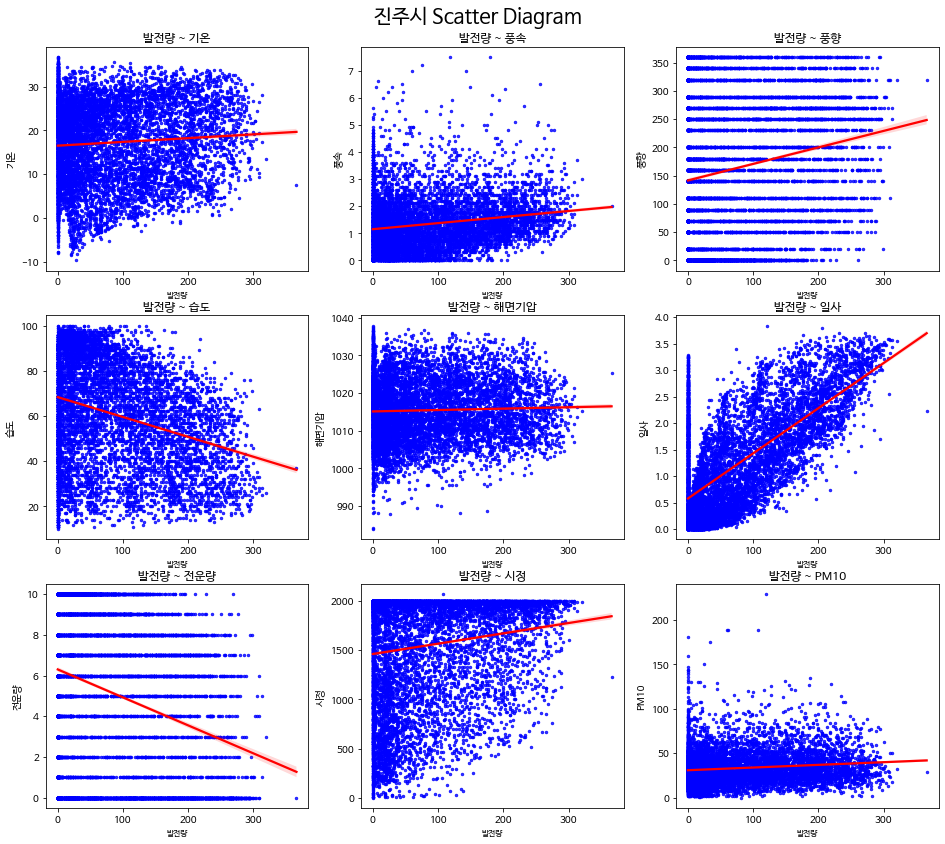

In [92]:
scatter(Jj_df, '발전량', "진주시")

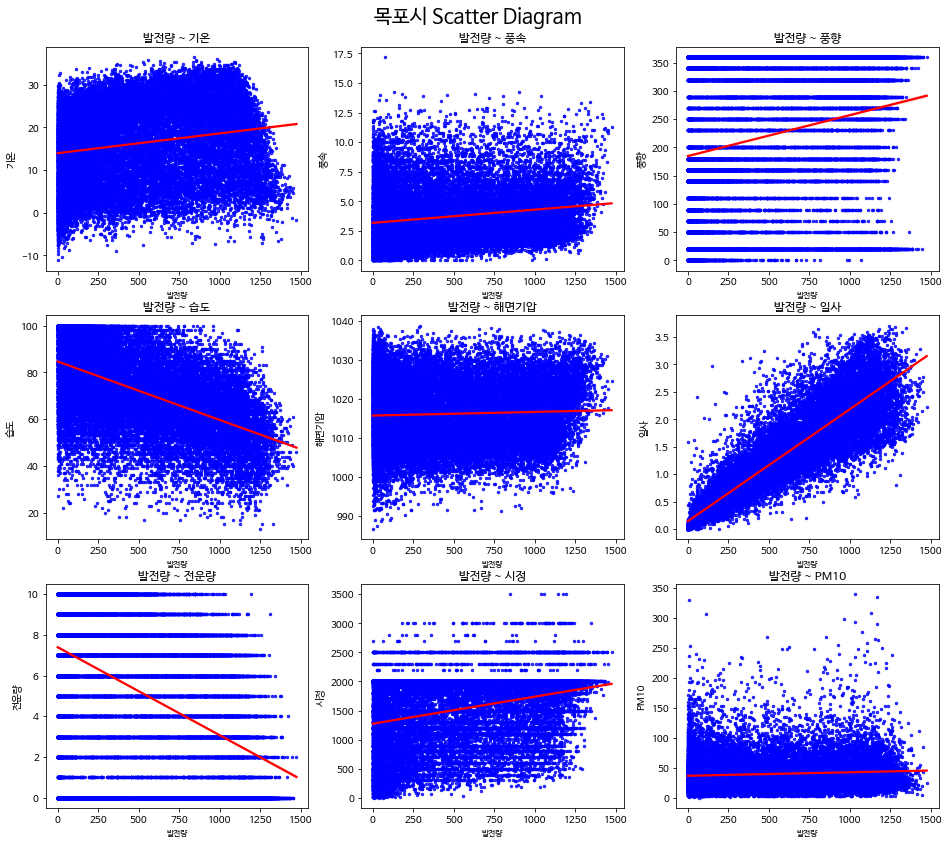

In [96]:
scatter(Mp_df, '발전량', "목포시")

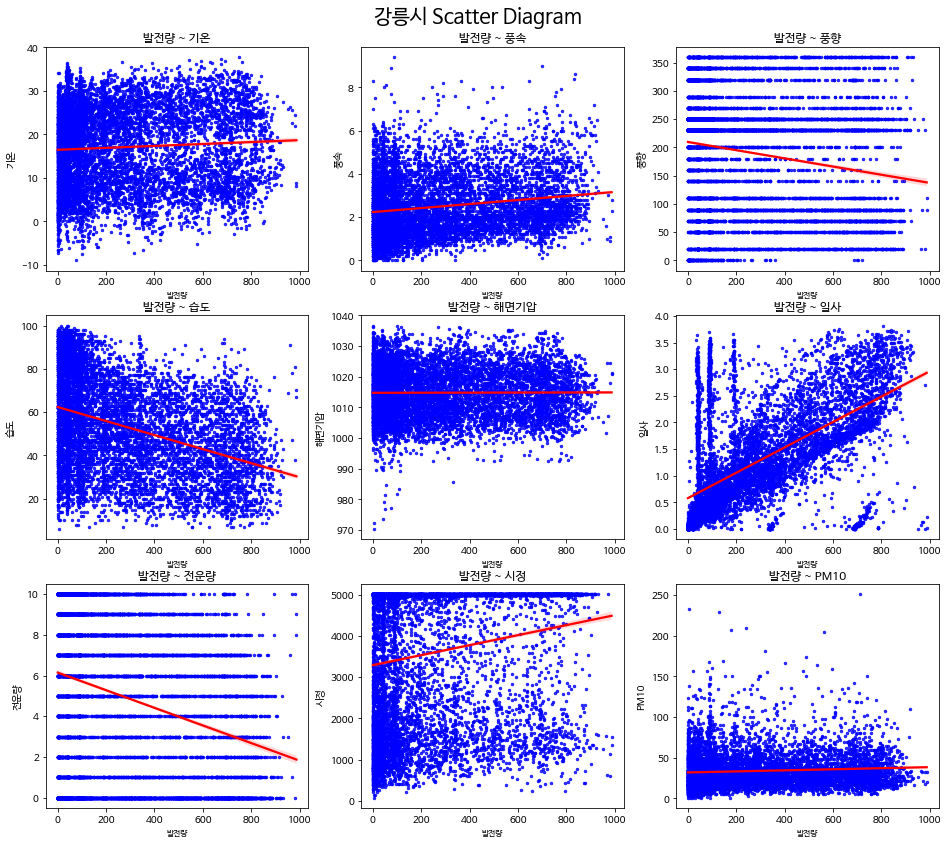

In [97]:
scatter(Gn_df, '발전량', "강릉시")

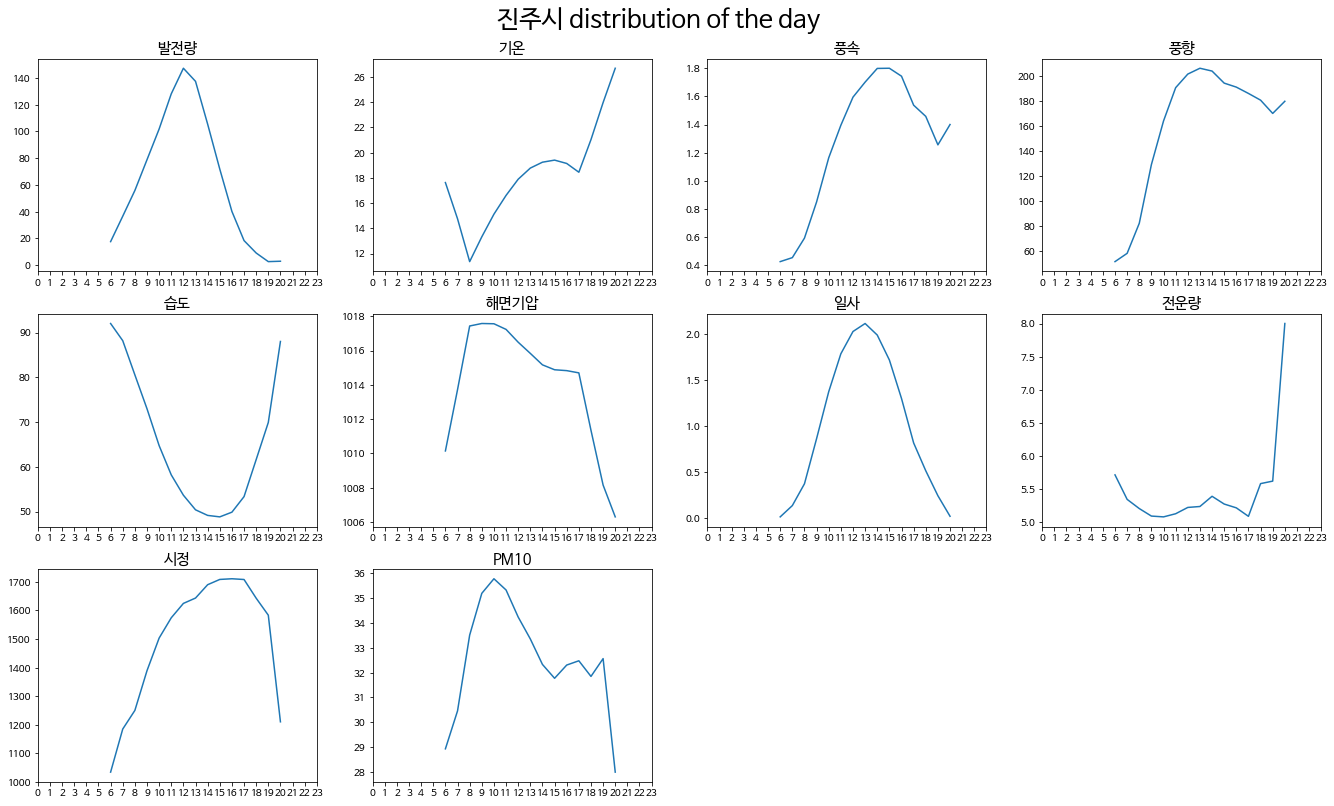

In [101]:
day_plot(Jj_df, '진주시')

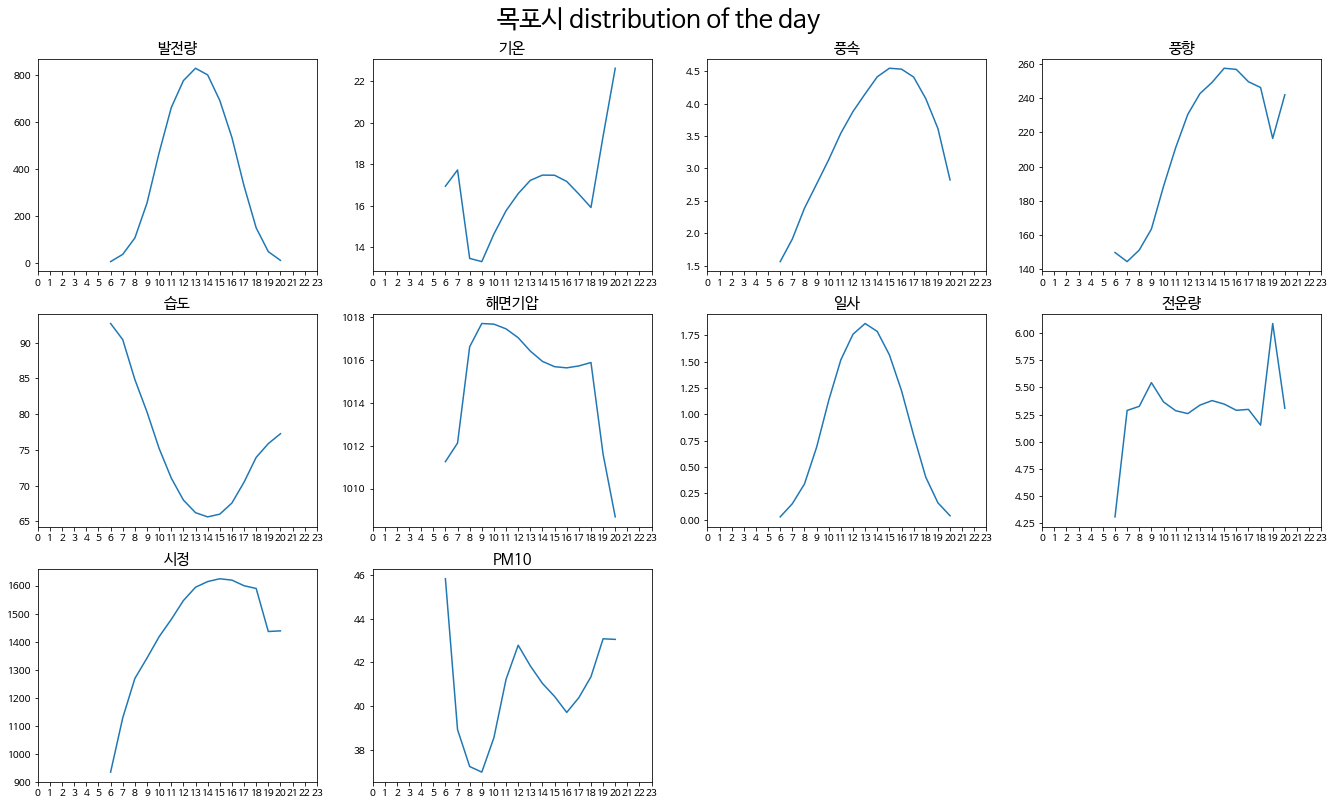

In [102]:
day_plot(Mp_df, '목포시')

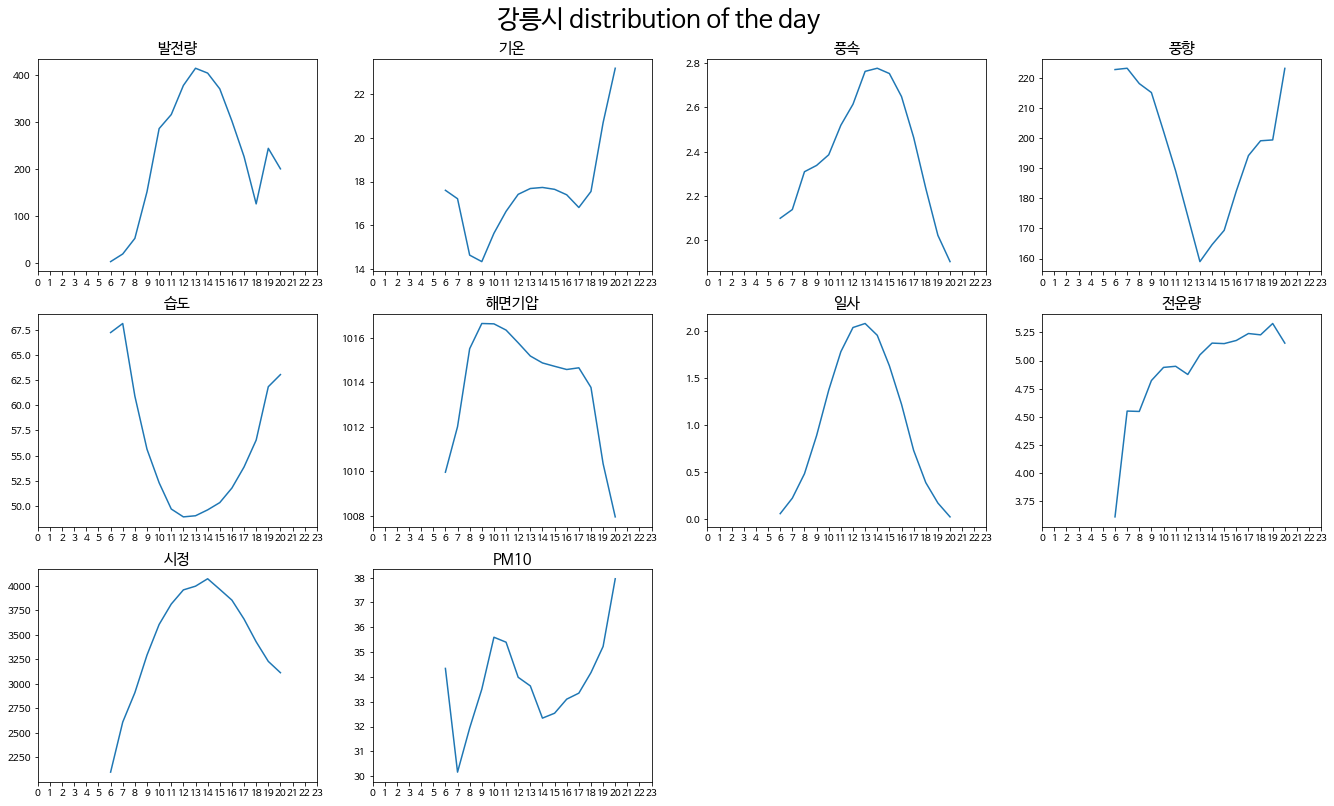

In [103]:
day_plot(Gn_df, '강릉시')

# Save data


In [104]:
data.to_csv('/content/gdrive/MyDrive/SolarPower/TestData.csv', index=None) #편차 열 생성 데이터